In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline
plt.style.use(u'fivethirtyeight')

path = '/Users/zhouzhirui/Documents/data/zillow/'
os.chdir(path)
os.listdir()

properties = pd.read_csv('properties_2016.csv')
train = pd.read_csv('train_2016_v2.csv',parse_dates=["transactiondate"])
properties_info = pd.read_csv('featureInfo_utf8.csv')

map_dict = dict(zip(properties_info.Feature,properties_info.feature_map))
properties.columns = map(lambda x: map_dict[x], properties.columns)

/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 缺失值特征

In [2]:
properties = properties.fillna(np.nan)
properties['_nan_num'] = properties.isnull().sum(axis=1)

area_columns = [i for i in properties.columns if i[:4] == 'area']
properties['_nan_area_num'] = properties[area_columns].isnull().sum(axis=1)

region_columns = [i for i in properties.columns if i[:6] == 'region']
region_columns.extend(['longitude','latitude','fips'])
properties['_nan_region_num'] = properties[region_columns].isnull().sum(axis=1)

tax_columns = [i for i in properties.columns if i[:3] == 'tax']
properties['_nan_tax_num'] = properties[tax_columns].isnull().sum(axis=1)

## region数据处理

In [3]:
region_columns = [i for i in properties.columns if i[:6] == 'region']
region_columns.extend(['longitude','latitude','fips'])
region_columns

['region_city',
 'region_county',
 'region_neighbor',
 'region_zip',
 'longitude',
 'latitude',
 'fips']

### 删除fips

In [8]:
properties.drop('fips',axis=1,inplace=True)
region_columns.remove('fips')

In [9]:
properties[region_columns].isnull().sum()

region_city          62845
region_county        11437
region_neighbor    1828815
region_zip           13980
longitude            11437
latitude             11437
dtype: int64

### 填充region city na values,增加对应的nan标签

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn_city = KNeighborsClassifier()
tmp = properties[['region_city','latitude','longitude']].dropna().copy()
knn = KNeighborsClassifier()
knn.fit(tmp[['latitude','longitude']].values,tmp.region_city.values)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [10]:
knn.score(tmp[['latitude','longitude']].values,tmp.region_city.values)

0.99899020384810699

In [11]:
misscity_id = properties[(properties.region_city.isnull())&(-properties.longitude.isnull())].parcelid.values
misscity_id

array([11114347, 11116947, 11681747, ..., 11126286, 11025289, 14599147])

In [15]:
misscity_city = knn.predict(properties[properties.parcelid.isin(misscity_id)][['latitude','longitude']].values)

In [16]:
properties.loc[properties.parcelid.isin(misscity_id),'region_city'] = misscity_city

In [13]:
properties['_nan_region_city'] = 0
properties.loc[properties.parcelid.isin(misscity_id),'_nan_region_city'] = 1

In [17]:
del misscity_city,misscity_id,knn,knn_city

### 填充 zip, 增加nan_zip label

In [20]:
properties[region_columns].isnull().sum()

region_city          11437
region_county        11437
region_neighbor    1828815
region_zip           13980
longitude            11437
latitude             11437
dtype: int64

In [21]:
knn = KNeighborsClassifier()
tmp = properties[['region_zip','latitude','longitude']].dropna().copy()
knn.fit(tmp[['latitude','longitude']].values,tmp.region_zip.values)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [22]:
misszip_id = properties[(properties.region_zip.isnull())&(-properties.longitude.isnull())].parcelid.values
misszip_id

array([76914147, 76914347, 76914547, ..., 14510752, 17258653, 14599147])

In [23]:
misscity_zip = knn.predict(properties[properties.parcelid.isin(misszip_id)][['latitude','longitude']].values)

In [24]:
properties.loc[properties.parcelid.isin(misszip_id),'region_zip'] = misscity_zip

In [25]:
properties['_nan_region_zip'] = 0
properties.loc[properties.parcelid.isin(misszip_id),'_nan_region_zip'] = 1

In [26]:
del misscity_zip,misszip_id,knn,tmp

In [27]:
properties[region_columns].isnull().sum()

region_city          11437
region_county        11437
region_neighbor    1828815
region_zip           11437
longitude            11437
latitude             11437
dtype: int64

## Area 数据处理

In [28]:
area_columns = [i for i in list(properties.columns) if 'area' == i[:4]]
area_columns

['area_basement',
 'area_firstfloor_finished',
 'area_total_calc',
 'area_live_finished',
 'area_liveperi_finished',
 'area_total_finished',
 'area_unknown',
 'area_base',
 'area_garage',
 'area_lot',
 'area_pool',
 'area_patio',
 'area_shed']

In [35]:
properties[area_columns].isnull().sum()

area_basement               2983589
area_firstfloor_finished    2782500
area_total_calc               55565
area_live_finished           276033
area_liveperi_finished      2977545
area_total_finished         2794419
area_unknown                2782500
area_base                   2963216
area_garage                 2101950
area_lot                     276099
area_pool                   2957257
area_patio                  2904862
area_shed                   2982570
dtype: int64

In [43]:
properties[['area_total_calc','area_total_finished','area_base','area_live_finished','area_liveperi_finished']].corr()

,area_total_calc,area_total_finished,area_base,area_live_finished,area_liveperi_finished
area_total_calc,1.000000,0.999994,1.0,1.0,1.0
area_total_finished,0.999994,1.000000,NaN,1.0,NaN
area_base,1.000000,NaN,1.0,NaN,NaN
area_live_finished,1.000000,1.000000,NaN,1.0,NaN
area_liveperi_finished,1.000000,NaN,NaN,NaN,1.0


相关系数几乎全为1

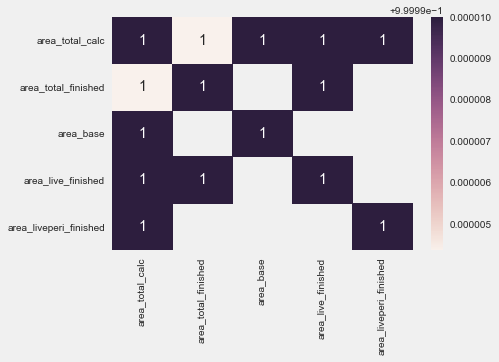

In [42]:
sns.heatmap(properties[['area_total_calc','area_total_finished','area_base','area_live_finished','area_liveperi_finished']].corr(),annot=True)

把唯一不为1 area_total_finished 和 area_total_calc 拉出来看看

In [30]:
properties[properties.area_total_calc!=properties.area_total_finished][['parcelid','area_total_calc','area_total_finished']].dropna()

,parcelid,area_total_calc,area_total_finished
1011473,17053873,2603.0,5206.0
2276060,17231357,5712.0,11424.0
2959851,17231374,4944.0,9888.0


In [31]:
properties[properties.parcelid.isin([17053873.,17231357.,17231374.])][area_columns]

,area_basement,area_firstfloor_finished,area_total_calc,area_live_finished,area_liveperi_finished,area_total_finished,area_unknown,area_base,area_garage,area_lot,area_pool,area_patio,area_shed
1011473,NaN,2603.0,2603.0,NaN,NaN,5206.0,2603.0,NaN,0.0,182952.0,NaN,NaN,NaN
2276060,NaN,2856.0,5712.0,NaN,NaN,11424.0,2856.0,NaN,0.0,11169.0,NaN,3120.0,NaN
2959851,NaN,2858.0,4944.0,NaN,NaN,9888.0,2858.0,NaN,0.0,9429.0,NaN,884.0,NaN


看下其他数据，area_total_calc更加合理

In [33]:
properties[(-properties.area_total_calc.isnull())&(properties.area_total_finished.isnull())].shape

(2738854, 63)

In [32]:
properties[(properties.area_total_calc.isnull())&(-properties.area_total_finished.isnull())].shape

(0, 63)

### 删除 area_totle_finished
### 增加特征 finished空，calc不为空

In [44]:
properties['_nan_area_totle_finished'] = 0
properties.loc[properties[(-properties.area_total_calc.isnull())&(properties.area_total_finished.isnull())].index,
              '_nan_area_totle_finished'] = 1
del properties['_nan_area_totle_finished']

### 删除 area_base
### 增加特征 base空，calc不为空

In [45]:
properties['_nan_area_base'] = 0
properties.loc[properties[(-properties.area_total_calc.isnull())&(properties.area_base.isnull())].index,
              '_nan_area_base'] = 1
del properties['area_base']
area_columns.remove('area_base')
area_columns.remove('area_total_finished')

### 删除 area_live_finished
### 删除 area_liveperi_finished
### 增加特征 livef空，calc不为空
### 增加特征 liveperi为空，calc不为空

In [48]:
properties['_nan_area_live_finished'] = 0
properties['_nan_area_liveperi_finished'] = 0

properties.loc[properties[(-properties.area_total_calc.isnull())&(properties.area_live_finished.isnull())].index,
              '_nan_area_live_finished'] = 1
properties.loc[properties[(-properties.area_total_calc.isnull())&(properties.area_liveperi_finished.isnull())].index,
              '_nan_area_liveperi_finished'] = 1
del properties['area_live_finished']
del properties['area_liveperi_finished']
area_columns.remove('area_live_finished')
area_columns.remove('area_liveperi_finished')

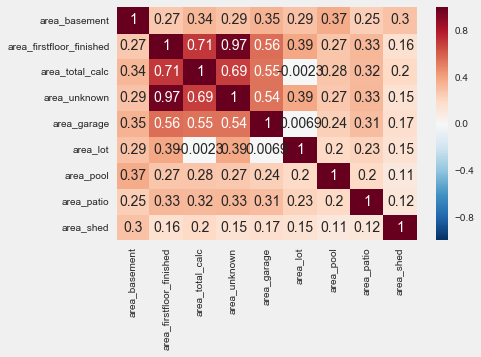

In [49]:
sns.heatmap(properties[area_columns].corr(),annot=True)

好看了很多。。再看看area_unkown，官方解释中，这个变量和area_firstfloor_finished是一样的，两个的相关系数也达到了0.97

In [50]:
properties[['area_unknown','area_firstfloor_finished']].isnull().sum()

area_unknown                2782500
area_firstfloor_finished    2782500
dtype: int64

In [51]:
properties[['area_unknown','area_firstfloor_finished']].dropna().head()

,area_unknown,area_firstfloor_finished
295,4969.0,4969.0
296,1080.0,1080.0
297,780.0,780.0
298,1250.0,1250.0
299,1404.0,1404.0


unknown 和 firstfloor_finished不相等的抽出来看看

In [52]:
tmp = properties[properties.area_unknown!=properties.area_firstfloor_finished][['area_unknown','area_firstfloor_finished','area_total_calc']].dropna().copy()

In [53]:
tmp['unknown_total'] = tmp.area_unknown/tmp.area_total_calc
tmp['firstfloor_total'] = tmp.area_firstfloor_finished/tmp.area_total_calc

In [54]:
tmp.describe()

,area_unknown,area_firstfloor_finished,area_total_calc,unknown_total,firstfloor_total
count,881.000000,881.000000,881.000000,881.000000,881.000000
mean,3793.354143,1880.271283,2496.496027,1.613732,0.800962
std,2265.744681,1116.091729,1598.208624,0.485708,0.252691
min,289.000000,105.000000,400.000000,0.179104,0.042021
25%,2271.000000,1115.000000,1416.000000,1.230378,0.592544
50%,3271.000000,1622.000000,2120.000000,1.746634,0.874826
75%,4716.000000,2404.000000,3063.000000,1.918428,1.000000
max,25686.000000,10945.000000,18117.000000,4.268293,1.877973


unknown 不合理的很多，比总面积还大0.0？firstfloor_finished还好一点；下午讨论这个变量

## Num 

In [76]:
num_columns = [i for i in properties.columns if 'num' == i[:3]]
num_columns

['num_bathroom',
 'num_bedroom',
 'num_bathroom_calc',
 'num_fireplace',
 'num_bath',
 'num_garage',
 'num_pool',
 'num_room',
 'num_75_bath',
 'num_unit',
 'num_story']

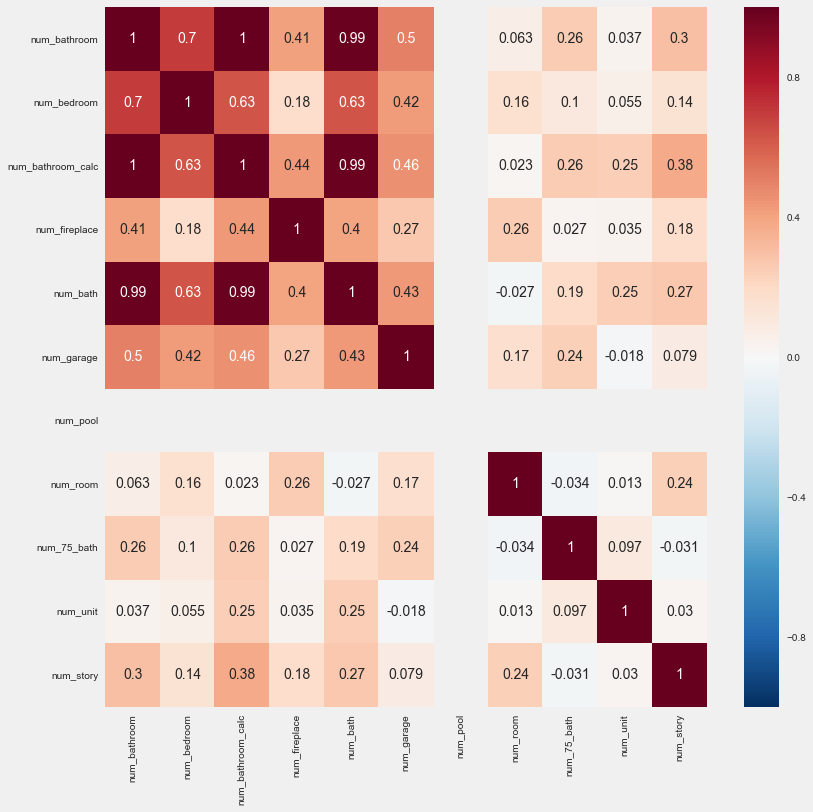

In [77]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(properties[num_columns].corr(),annot=True)

有3个变量相关系数0.99

In [61]:
properties[['num_bathroom','num_bathroom_calc','num_bath']].corr()

,num_bathroom,num_bathroom_calc,num_bath
num_bathroom,1.00000,1.00000,0.98736
num_bathroom_calc,1.00000,1.00000,0.98736
num_bath,0.98736,0.98736,1.00000


In [62]:
properties[['num_bathroom','num_bathroom_calc','num_bath']].isnull().sum()

num_bathroom          11462
num_bathroom_calc    128912
num_bath             128912
dtype: int64

In [78]:
properties[(properties.num_bathroom.isnull())&(-properties.num_bathroom_calc.isnull())]

,parcelid,aircon,architectural_style,area_basement,num_bathroom,num_bedroom,framing,quality,num_bathroom_calc,deck,...,censustractandblock,_nan_num,_nan_area_num,_nan_region_num,_nan_tax_num,_nan_region_city,_nan_region_zip,_nan_area_base,_nan_area_live_finished,_nan_area_liveperi_finished


## 删除 num_bathroom_calc 增加缺失标签

In [79]:
properties['_nan_bathroom_calc'] = 0
properties.loc[(properties.num_bathroom_calc.isnull())&(-properties.num_bathroom.isnull()),'_nan_bathroom_calc'] = 1
del properties['num_bathroom_calc']
num_columns.remove('num_bathroom_calc')

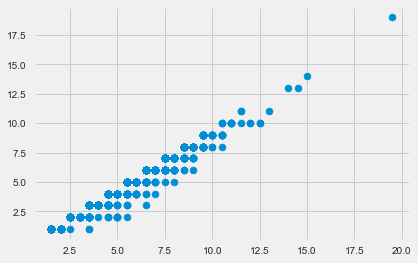

In [74]:
plt.scatter(properties[properties.num_bathroom!=properties.num_bath][['num_bathroom','num_bath']].dropna()['num_bathroom'],
           properties[properties.num_bathroom!=properties.num_bath][['num_bathroom','num_bath']].dropna()['num_bath'])

In [75]:
properties[properties.num_bathroom!=properties.num_bath][['num_bathroom','num_bath']].dropna()['num_bathroom'].shape

(311631,)

## num_bath 先留着

In [85]:
tax_columns = [i for i in properties.columns if i[:3]=='tax']

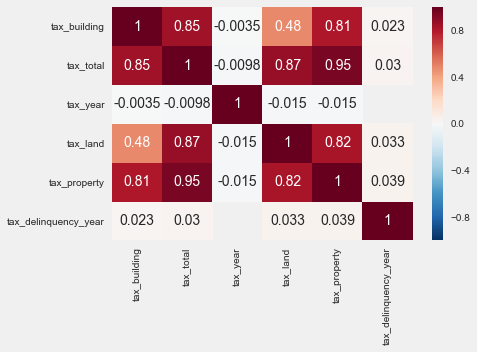

In [91]:
sns.heatmap(properties[tax_columns].corr(),annot=True)

### pool

In [105]:
pool_columns =  [i for i in properties.columns if 'pool' in i]

In [106]:
pool_columns

['num_pool', 'area_pool', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7']

In [107]:
properties[pool_columns].corr()

,num_pool,area_pool,pooltypeid10,pooltypeid2,pooltypeid7
num_pool,NaN,NaN,NaN,NaN,NaN
area_pool,NaN,1.0,NaN,NaN,NaN
pooltypeid10,NaN,NaN,NaN,NaN,NaN
pooltypeid2,NaN,NaN,NaN,NaN,NaN
pooltypeid7,NaN,NaN,NaN,NaN,NaN


In [109]:
properties.to_csv('/Users/zhouzhirui/Documents/data/properties_processing.csv',index=None)